In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
import sys
import warnings

warnings.filterwarnings("ignore")
from itertools import product
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm

%matplotlib inline


from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)


In [4]:
df = pd.read_csv('ВС DS Сбер data.csv', delimiter=';')

In [9]:
df.REPORTDATE = pd.to_datetime(df['REPORTDATE'], format='%d.%m.%Y')

In [14]:
df.describe()

,VALUE
count,2.111000e+03
mean,3.389668e+10
std,1.875474e+10
min,3.282810e+09
25%,1.824160e+10
50%,3.021352e+10
75%,4.758339e+10
max,7.822860e+10


In [22]:
print(df.REPORTDATE.min(), df.REPORTDATE.max())

2013-12-30 00:00:00 2019-10-10 00:00:00


In [15]:
df.isna().sum()

REPORTDATE    0
VALUE         0
dtype: int64

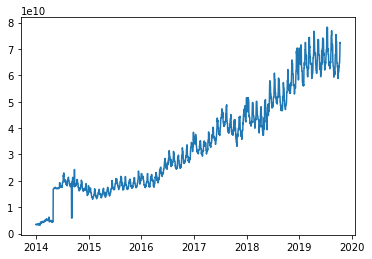

In [19]:
plt.plot(df.REPORTDATE, df.VALUE);

In [29]:
def moving_average(series, n):
    return np.average(series[-n:])

In [30]:
moving_average(
    df.VALUE, 24
) # посмотрим на прогноз, построенный по последнему наблюдаемому дню (24 часа)

63880708985.416664

In [41]:
def plotMovingAverage(series, n, plot_bounds=False):

    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """

    rolling_mean = series.rolling(window=n).mean()

    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_bounds:
        rolling_std = series.rolling(window=n).std()
        upper_bound = rolling_mean + 1.96 * rolling_std
        lower_bound = rolling_mean - 1.96 * rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    # Деления соответствуют понедельникам что дает представление о недельной цикличности графика
    # ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    # Отображать значение дат в формате yy-mm-dd
    # ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d"))
    plt.xticks(rotation=45)


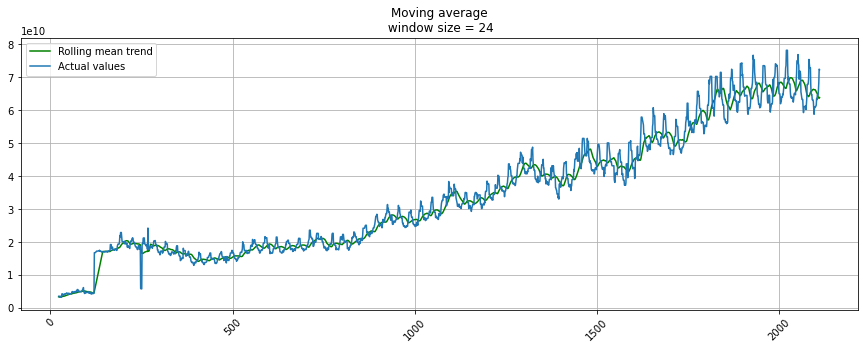

In [42]:
plotMovingAverage(df.VALUE, 24)  # сглаживаем по дням

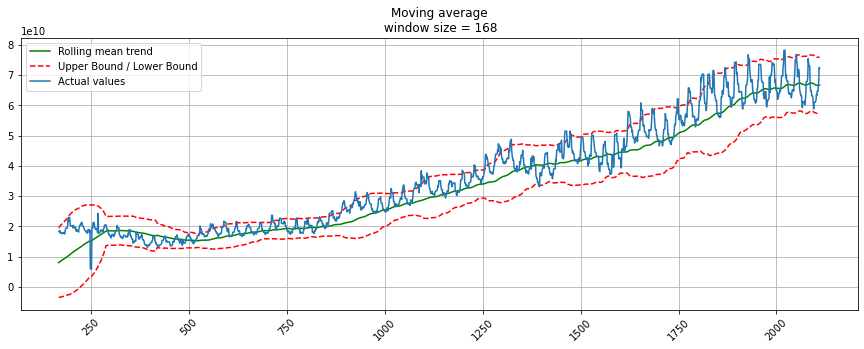

In [43]:
plotMovingAverage(df.VALUE, 24 * 7, plot_bounds=True)  # сглаживаем по неделям

In [44]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n - 1] * weights[n]
    return float(result)

In [45]:
weighted_average(df.VALUE, [0.6, 0.2, 0.1, 0.07, 0.03])

71292675423.6

In [46]:
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n - 1])
    return result

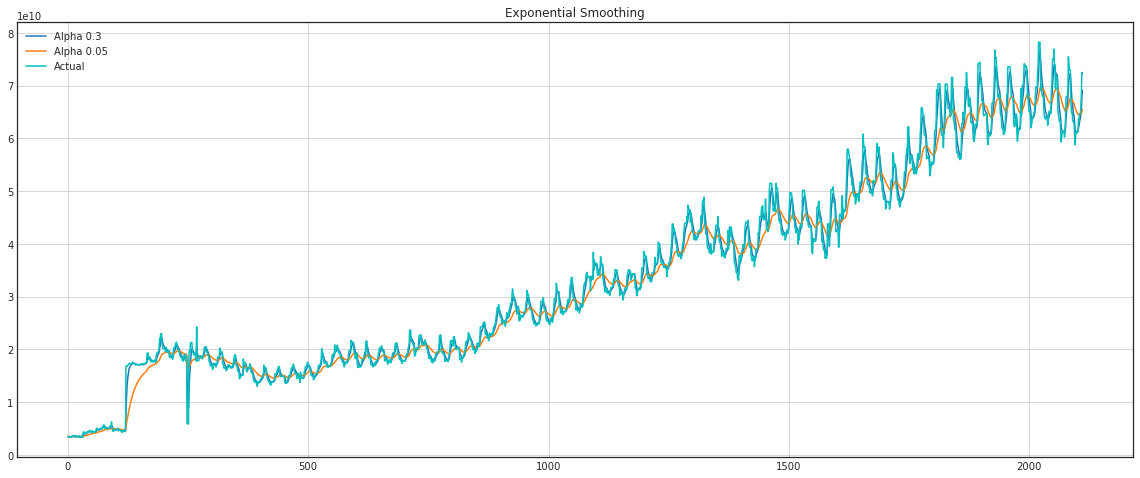

In [47]:
with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(
            exponential_smoothing(df.VALUE, alpha), label="Alpha {}".format(alpha)
        )
    plt.plot(df.VALUE.values, "c", label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)

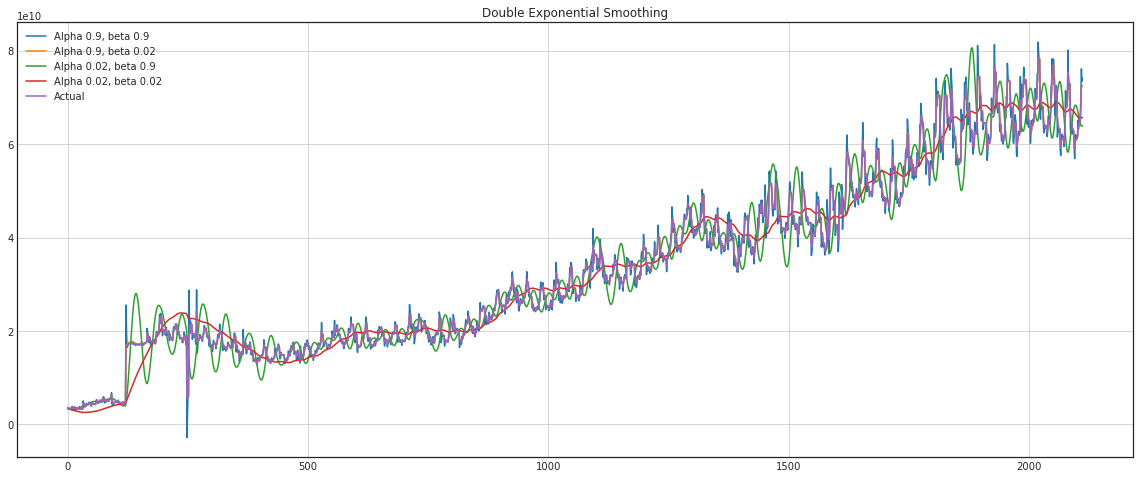

In [50]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


with plt.style.context("seaborn-white"):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(
                double_exponential_smoothing(df.VALUE, alpha, beta),
                label="Alpha {}, beta {}".format(alpha, beta),
            )
    plt.plot(df.VALUE.values, label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [68]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )

                continue
            if i >= len(self.series):  # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [115]:
from sklearn.model_selection import TimeSeriesSplit


def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=12*6,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))


In [116]:
%%time
data = df.VALUE[:-500]  # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds=((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.004677654839508549 0.021973571220476495 0.09626499465274946
CPU times: user 1min 1s, sys: 69.1 ms, total: 1min 1s
Wall time: 1min 1s


In [117]:
# Передаем оптимальные значения модели,
data = df.VALUE
model = HoltWinters(
    data[:-128],
    slen=30,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=128,
    scaling_factor=2.56,
)
model.triple_exponential_smoothing()

In [118]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN] * len(data))
    Anomalies[data.values < model.LowerBond] = data.values[
        data.values < model.LowerBond
    ]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label="Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label="Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(
        x=range(0, len(model.result)),
        y1=model.UpperBond,
        y2=model.LowerBond,
        alpha=0.5,
        color="grey",
    )
    plt.plot(data.values, label="Actual")
    plt.plot(Anomalies, "o", markersize=10, label="Anomalies")
    plt.axvspan(len(data) - 128, len(data), alpha=0.5, color="lightgrey")
    plt.grid(True)
    plt.axis("tight")
    plt.legend(loc="best", fontsize=13);


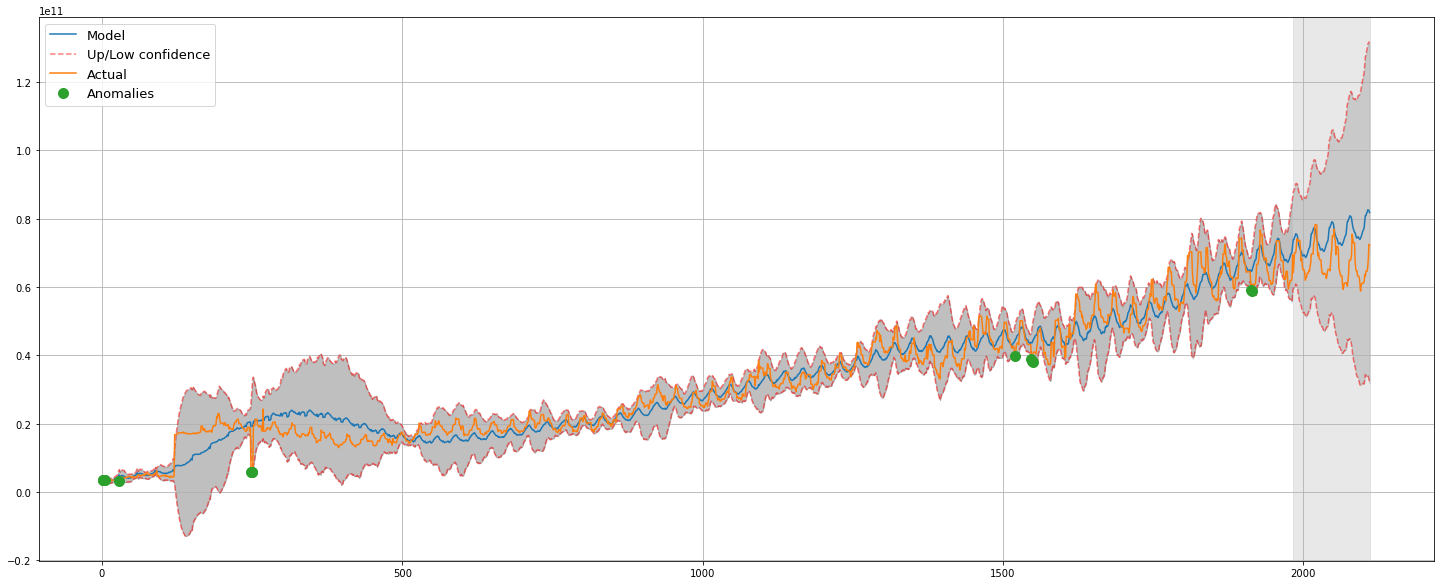

In [119]:
plotHoltWinters()

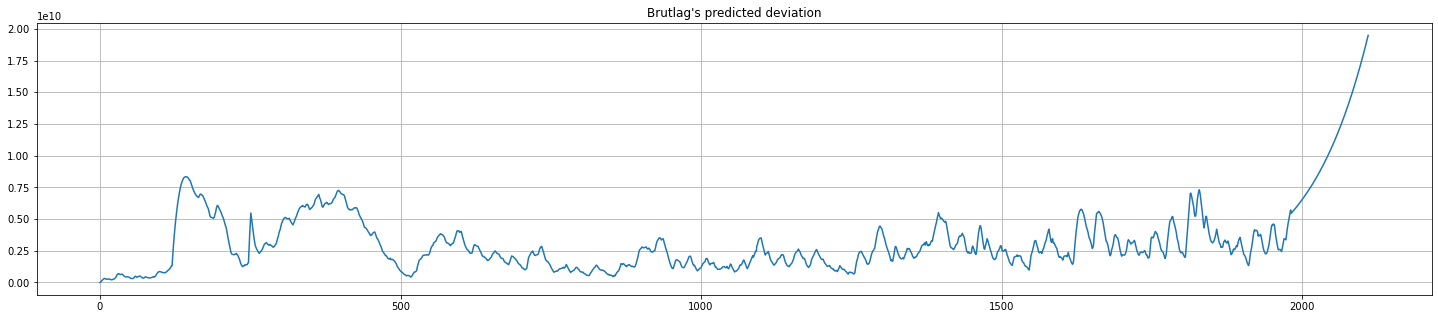

In [93]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis("tight")
plt.title("Brutlag's predicted deviation");

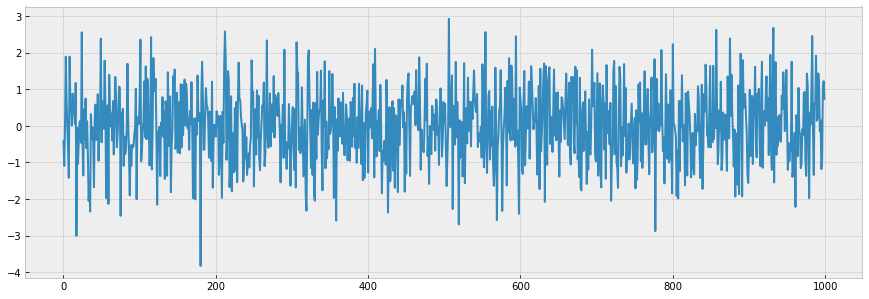

In [94]:
white_noise = np.random.normal(size=1000)
with plt.style.context("bmh"):
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

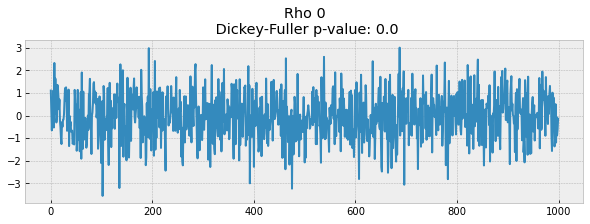

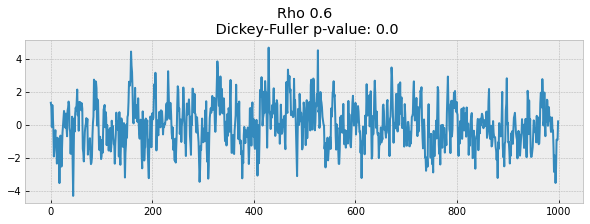

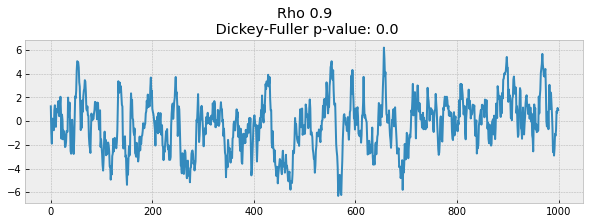

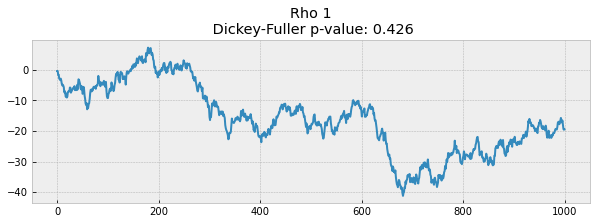

In [95]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t - 1] + w[t]

    with plt.style.context("bmh"):
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title(
            "Rho {}\n Dickey-Fuller p-value: {}".format(
                rho, round(sm.tsa.stattools.adfuller(x)[1], 3)
            )
        )


for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

In [121]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

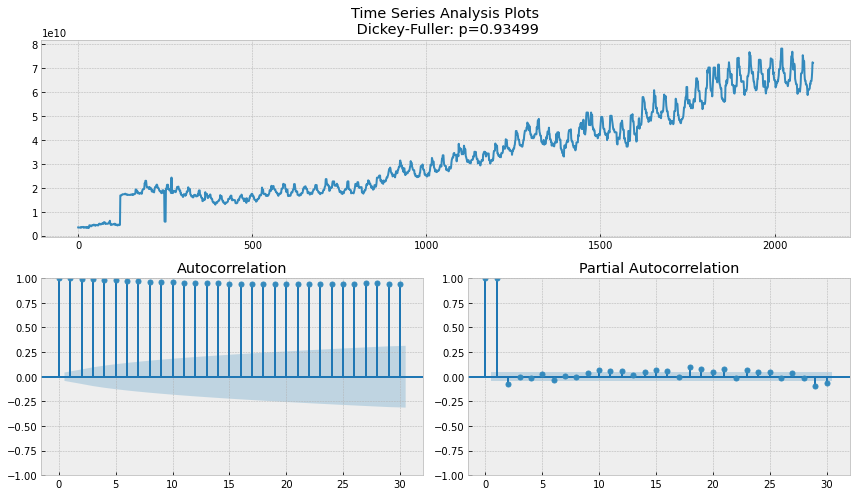

In [122]:
tsplot(df.VALUE, lags=30)

Оптимальный параметр преобразования Бокса-Кокса: 0.488251


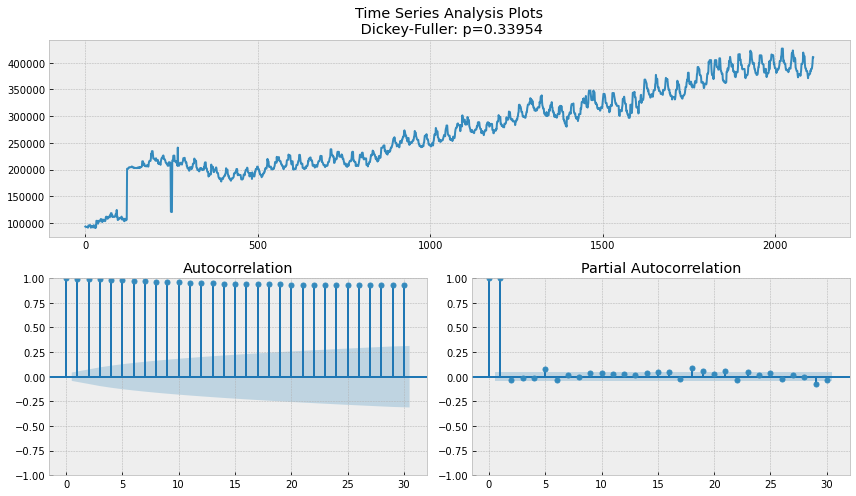

In [123]:
def invboxcox(y, lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)


data = df.copy()
data["Users_box"], lmbda = scs.boxcox(
    data.VALUE + 1
)  # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Users_box, lags=30)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

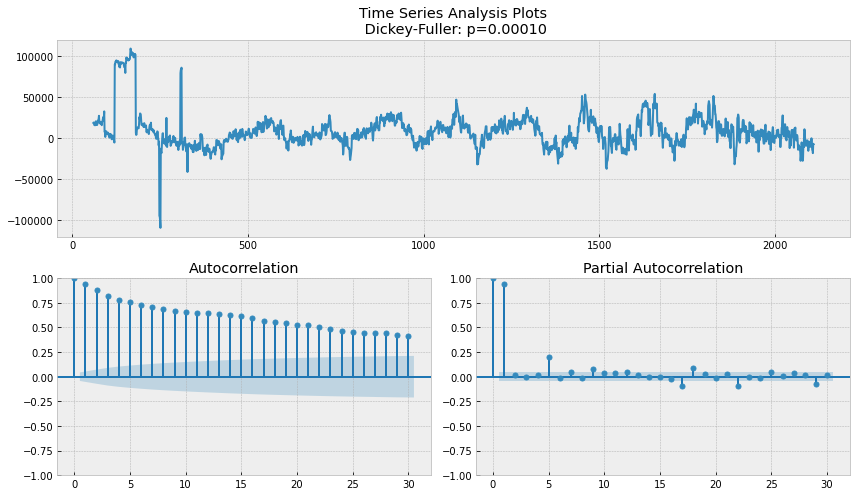

In [124]:
data["Users_box_season"] = data.Users_box - data.Users_box.shift(12 * 5)
tsplot(data.Users_box_season[12 * 5 :], lags=30)

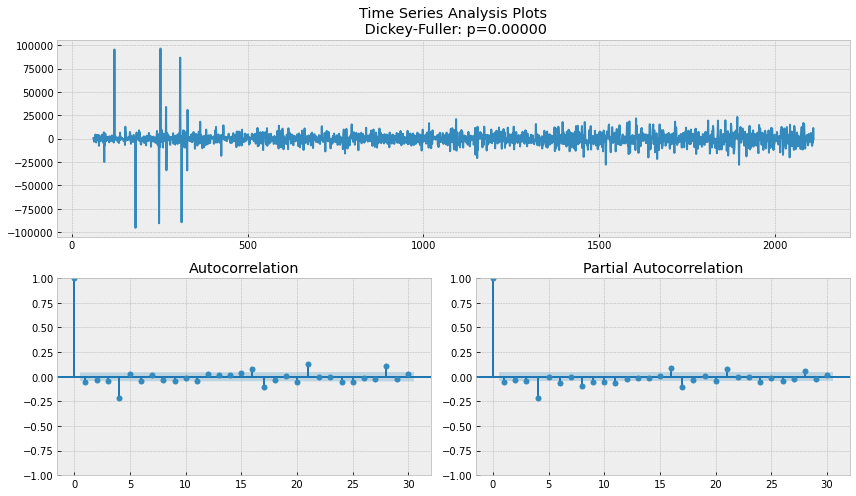

In [125]:
data["Users_box_season_diff"] = data.Users_box_season - data.Users_box_season.shift(1)
tsplot(data.Users_box_season_diff[12 * 5 + 1 :], lags=30)

In [126]:
# setting initial values and some bounds for them
ps = range(2, 5)
d = 1
qs = range(2, 5)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)
s = 24  # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [127]:
def optimizeSARIMA(series, parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        series – the time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(
                series,
                order=(param[0], d, param[1]),
                seasonal_order=(param[2], D, param[3], s),
            ).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table

In [128]:
%%time
result_table = optimizeSARIMA(data.Users_box_season, parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 16min 12s, sys: 8.94 s, total: 16min 21s
Wall time: 4min 47s


In [129]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(
    ads.Ads, order=(p, d, q), seasonal_order=(P, D, Q, s)
).fit(disp=-1)

NameError: name 'ads' is not defined

In [ ]:
print(best_model.summary())


In [ ]:
tsplot(best_model.resid[24:], lags=30)

In [ ]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(
    best_model.predict(start=data.shape[0], end=data.shape[0] + 100), lmbda
)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Users.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color="r", label="model")
plt.title(
    "SARIMA model\n Mean absolute error {} users".format(
        round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))
    )
)
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color="lightgrey")
plt.grid(True)

In [130]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [132]:
data = pd.DataFrame(df.copy())

In [135]:
data = data.set_index('REPORTDATE')

In [136]:
data.columns = ["y"]

data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data["is_weekend"] = data.weekday.isin([5, 6]) * 1
data.head()

,y,hour,weekday,is_weekend
REPORTDATE,,,,
2013-12-30,3457625638,0,0,0
2013-12-31,3417092149,0,1,0
2014-01-01,3417092149,0,2,0
2014-01-02,3417092149,0,3,0
2014-01-03,3417092149,0,4,0


In [137]:
code_mean(data, "weekday", "y")

{0: 33517276381.917217,
 1: 33624060578.490067,
 2: 33784781724.986755,
 3: 33919525983.78808,
 4: 34103136867.26246,
 5: 34164795645.687706,
 6: 34165618118.08638}

In [169]:
def prepareData(data, lag_start=5, lag_end=13, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data = data.set_index('REPORTDATE')
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # data.index = data.index.to_datetime()
    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["weekday_average"] = list(
        map(code_mean(data[:test_index], "weekday", "y").get, data.weekday)
    )
    data["month_average"] = list(
        map(code_mean(data[:test_index], "month", "y").get, data.month)
    )

    # выкидываем закодированные средними признаки
    data.drop(["month", "weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test


In [172]:
data_lr = df.copy()
X_train, X_test, y_train, y_test = prepareData(
    data_lr, test_size=0.3
)

In [173]:
X_train

,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,is_weekend,weekday_average,month_average
0,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.457626e+09,1,2.394516e+10,2.117241e+10
1,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,1,2.394633e+10,2.117241e+10
2,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,0,2.332959e+10,2.117241e+10
3,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,0,2.361359e+10,2.117241e+10
4,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,0,2.369953e+10,2.117241e+10
...,...,...,...,...,...,...,...,...,...,...,...
1473,4.478707e+10,4.441070e+10,4.546832e+10,4.608766e+10,5.056772e+10,5.056772e+10,5.056772e+10,5.150078e+10,0,2.361359e+10,2.117241e+10
1474,4.399021e+10,4.478707e+10,4.441070e+10,4.546832e+10,4.608766e+10,5.056772e+10,5.056772e+10,5.056772e+10,0,2.369953e+10,2.117241e+10
1475,4.399021e+10,4.399021e+10,4.478707e+10,4.441070e+10,4.546832e+10,4.608766e+10,5.056772e+10,5.056772e+10,0,2.377720e+10,2.117241e+10
1476,4.399021e+10,4.399021e+10,4.399021e+10,4.478707e+10,4.441070e+10,4.546832e+10,4.608766e+10,5.056772e+10,0,2.393132e+10,2.117241e+10


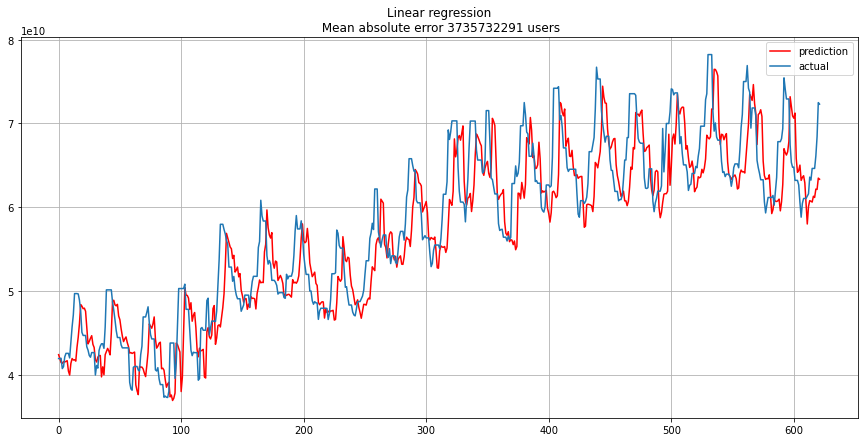

In [174]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(
    "Linear regression\n Mean absolute error {} users".format(
        round(mean_absolute_error(prediction, y_test))
    )
)
plt.grid(True);


In [187]:
lr_error = 3735732291

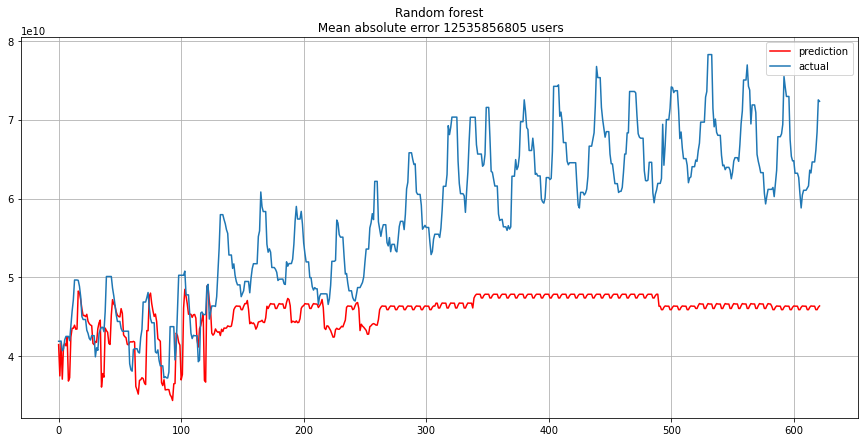

In [175]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title(
    "Random forest\n Mean absolute error {} users".format(
        round(mean_absolute_error(prediction, y_test))
    )
)
plt.grid(True);


In [176]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print("Size train set: {}".format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print("Size of each fold: {}".format(k))

    errors = np.zeros(number_folds - 1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print()
        split = float(i - 1) / i
        print(
            "Splitting the first " + str(i) + " chunks at " + str(i - 1) + "/" + str(i)
        )

        X = X_train[: (k * i)]
        y = y_train[: (k * i)]
        print(
            "Size of train + test: {}".format(X.shape)
        )  # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1) :]
        y_testFold = y[(index + 1) :]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i - 2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

In [177]:
performTimeSeriesCV(X_train, y_train, 5, lr, mean_absolute_error)

Size train set: (1478, 11)
Size of each fold: 295

Splitting the first 2 chunks at 1/2
Size of train + test: (590, 11)

Splitting the first 3 chunks at 2/3
Size of train + test: (885, 11)

Splitting the first 4 chunks at 3/4
Size of train + test: (1180, 11)

Splitting the first 5 chunks at 4/5
Size of train + test: (1475, 11)


2109848111.9996657

In [162]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     |████████████████████████████████| 255.9 MB 9.8 kB/s eta 0:00:011    |█████████▍                      | 74.7 MB 15.3 MB/s eta 0:00:12     |████████████████▎               | 129.9 MB 11.5 MB/s eta 0:00:11     |███████████████████             | 152.1 MB 11.2 MB/s eta 0:00:10     |███████████████████████         | 184.4 MB 14.7 MB/s eta 0:00:05     |████████████████████████▍       | 195.2 MB 7.5 MB/s eta 0:00:09     |████████████████████████████    | 223.2 MB 11.6 MB/s eta 0:00:03     |████████████████████████████▌   | 228.1 MB 10.3 MB/s eta 0:00:03MB 10.3 MB/s eta 0:00:02     |███████████████████████████████▍| 250.9 MB 6.4 MB/s eta 0:00:01


In [194]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(
        data, lag_start, lag_end, test_size
    )
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {"objective": "reg:squarederror", "booster": "gblinear"}
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(
        params,
        dtrain,
        metrics=("rmse"),
        verbose_eval=False,
        nfold=10,
        show_stdv=False,
        num_boost_round=trees,
    )

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv["test-rmse-mean"].argmin())

    # можно построить кривые валидации
    # cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv["test-rmse-mean"].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis("tight")
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test - scale * deviation
    upper = prediction_test + scale * deviation

    Anomalies = np.array([np.NaN] * len(y_test))
    Anomalies[y_test < lower] = y_test[y_test < lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    # plt.plot(lower, "r--", label="upper bond / lower bond")
    # plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title(
        "XGBoost Mean absolute error {} users".format(
            round(mean_absolute_error(prediction_test, y_test))
        )
    )
    plt.grid(True)
    plt.legend()
    print(round(mean_absolute_error(prediction_test, y_test)))

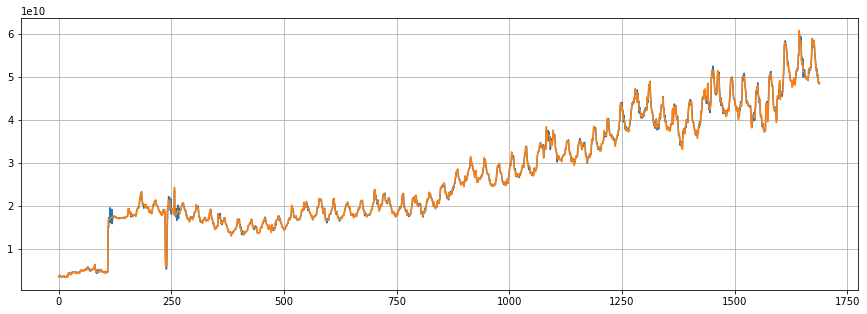

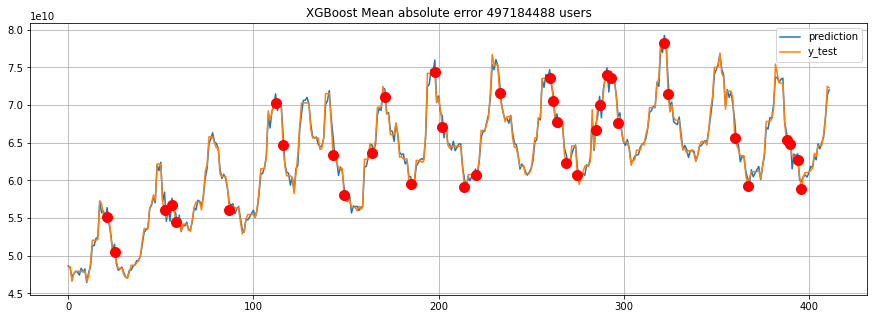

In [193]:
XGB_forecast(data_lr, test_size=0.2, lag_start=0, lag_end=12)

In [186]:
xboost_error = 2846270215

In [189]:
xboost_error - lr_error

-889462076

In [191]:
xboost_error > 1389080393

True

In [195]:
from sklearn.model_selection import train_test_split

In [199]:
data_lr

,REPORTDATE,VALUE
0,2013-12-30,3457625638
1,2013-12-31,3417092149
2,2014-01-01,3417092149
3,2014-01-02,3417092149
4,2014-01-03,3417092149
...,...,...
2106,2019-10-06,64630140507
2107,2019-10-07,66115288637
2108,2019-10-08,68424049766
2109,2019-10-09,72492897583


In [196]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):
    X = data.
    # исходные данные
    X_train, X_test, y_train, y_test = train_test_split(
        data, test_size=0.15
    )
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {"objective": "reg:squarederror", "booster": "gblinear"}
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(
        params,
        dtrain,
        metrics=("rmse"),
        verbose_eval=False,
        nfold=10,
        show_stdv=False,
        num_boost_round=trees,
    )

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv["test-rmse-mean"].argmin())

    # можно построить кривые валидации
    # cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv["test-rmse-mean"].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis("tight")
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test - scale * deviation
    upper = prediction_test + scale * deviation

    Anomalies = np.array([np.NaN] * len(y_test))
    Anomalies[y_test < lower] = y_test[y_test < lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    # plt.plot(lower, "r--", label="upper bond / lower bond")
    # plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title(
        "XGBoost Mean absolute error {} users".format(
            round(mean_absolute_error(prediction_test, y_test))
        )
    )
    plt.grid(True)
    plt.legend()
    print(round(mean_absolute_error(prediction_test, y_test)))

In [197]:
XGB_forecast(data_lr, test_size=0.2, lag_start=0, lag_end=12)

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
train_test_split()